Processed positions: X, Y, Z (rows as dimensions, cols as frames)
AnklePosition preview (first 10 frames):
[[0.584714  0.5843715 0.584726  0.58472   0.584311  0.5852565 0.584993
  0.5850375 0.585053  0.5851195]
 [0.5184535 0.5183675 0.5184905 0.5184685 0.518096  0.5180725 0.517945
  0.5179595 0.5178765 0.517928 ]
 [0.128403  0.128037  0.1283845 0.1284075 0.1287355 0.128118  0.128236
  0.1282105 0.1282195 0.1282   ]]


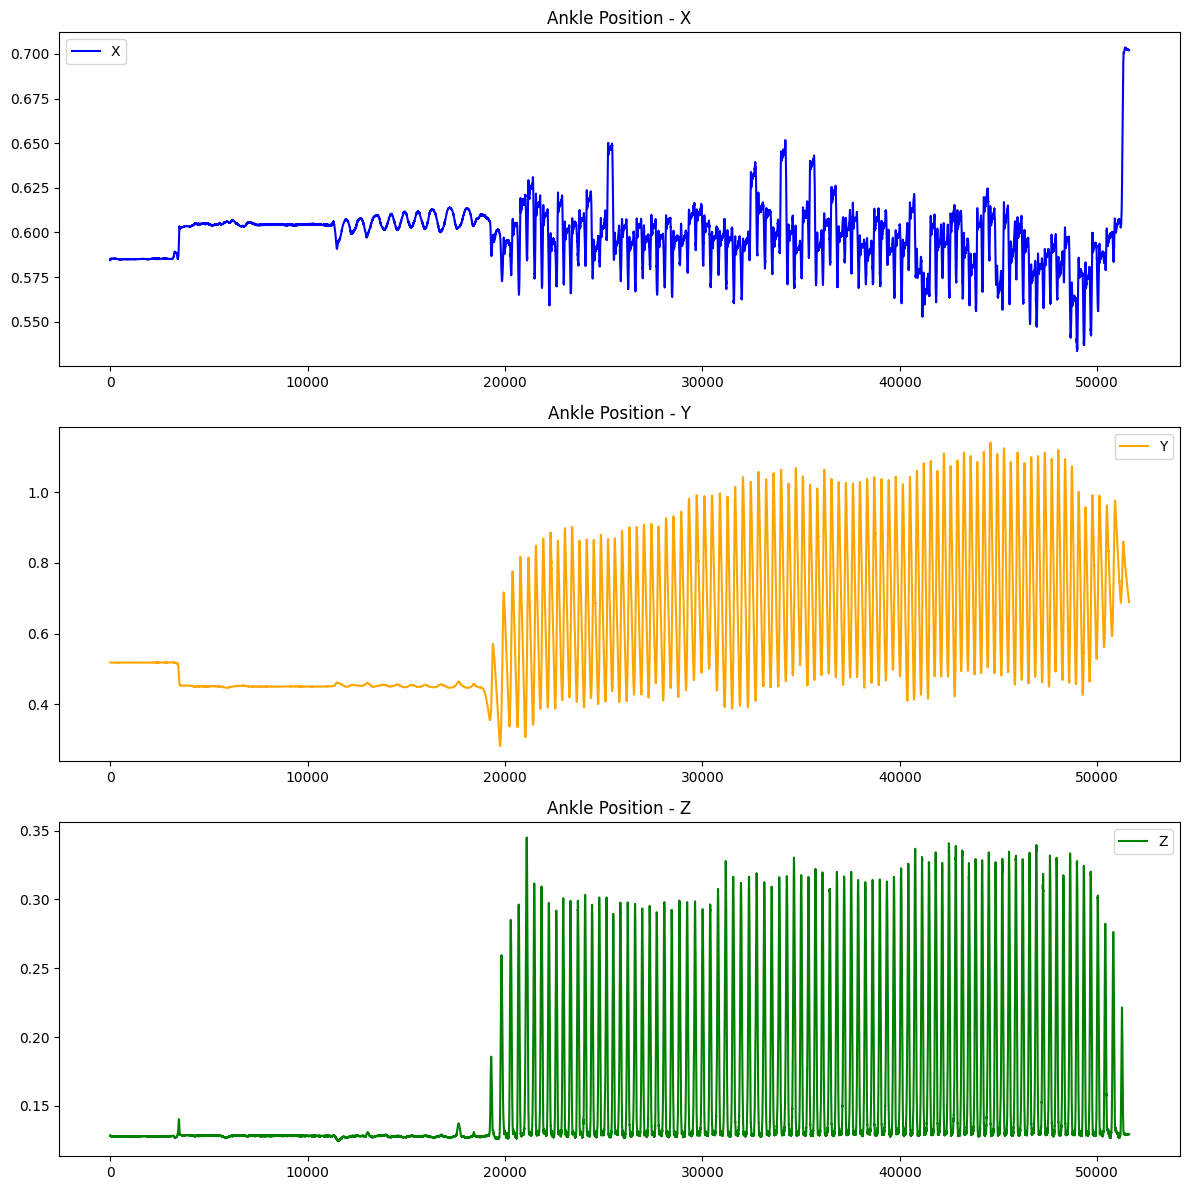

RLatAnkle shape: (3, 51613)
RMedAnkle shape: (3, 51613)
AnklePosition shape: (3, 51613)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


# 1. Read TSV file (skip first 11 lines, start from line 12)
tsv_file = 'Subject_01/T01-10/S01_T01.tsv'
trajectories_df = pd.read_csv(tsv_file, sep='\t', skiprows=11, header=None)

# 2. Calculate the right indexs of rows(from 0)
idx_RLatAnkle = 24  # RLatAnkle 的 X 坐标
idx_RMedAnkle = 27  # RMedAnkle 的 X 坐标

# 3. Get the axis data of `RLatAnkle` and `RMedAnkle` 
RLatAnkle = trajectories_df.iloc[:, idx_RLatAnkle:idx_RLatAnkle+3].values.T  # (3, Frames)
RMedAnkle = trajectories_df.iloc[:, idx_RMedAnkle:idx_RMedAnkle+3].values.T  # (3, Frames)


# 4. Calculate the center position of ankle
AnklePosition = (RLatAnkle + RMedAnkle) / 2  # (3, Frames)

AnklePosition /= 1000  # mm → m


# Making the test data
frames = np.arange(AnklePosition.shape[1])
X, Y, Z = AnklePosition[0, :], AnklePosition[1, :], AnklePosition[2, :]

print("Processed positions: X, Y, Z (rows as dimensions, cols as frames)")
print("AnklePosition preview (first 10 frames):")
print(AnklePosition[:, :10])

# 2. Setting the figure
plt.figure(figsize=(12, 12))

# 3. Plot x, y, z data
plt.subplot(3, 1, 1)
plt.plot(frames, X, label='X', color='b')
plt.legend()
plt.title("Ankle Position - X")

plt.subplot(3, 1, 2)
plt.plot(frames, Y, label='Y', color='orange')
plt.legend()
plt.title("Ankle Position - Y")

plt.subplot(3, 1, 3)
plt.plot(frames, Z, label='Z', color='g')
plt.legend()
plt.title("Ankle Position - Z")

# 4. Layout
plt.tight_layout()
plt.show(block=True)  # Make sure to block until the window is closed

# 5. Verify the data size
print(f"RLatAnkle shape: {RLatAnkle.shape}")  # (3, 51613)
print(f"RMedAnkle shape: {RMedAnkle.shape}")  # (3, 51613)
print(f"AnklePosition shape: {AnklePosition.shape}")  # (3, 51613)

/var/folders/t3/md7qww213qzg03zk21mthb6r0000gn/T/ipykernel_26708/3730768307.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  force_df = pd.read_csv('Subject_01/T01-10/S01_T01_f_6.tsv', sep='\t', skiprows=27, header=None)


Resampled Force shape: (3, 51613), COP shape: (3, 51613)
Moment Arm shape: (3, 51613), Force shape: (3, 51613)
Computed torque for 45205 frames out of 51613
Moment Arm X Min/Max: -0.951299250773577 to 0.3940737238270122 m
Ankle Position X Min/Max: 0.5335635 to 0.703591 m
COP Right X Min/Max: -0.6525622507735771 to 0.7337812238270122 m
Mean Ankle Torque (Y-axis): 65.51 N·m
Max Ankle Torque (Y-axis): 223.49 N·m
Min Ankle Torque (Y-axis): -17.86 N·m
Processed Torque data preview (first 10 frames):
[[230.28325571 230.12284446 227.33384939 233.33324599 240.13598491
  247.55803749 249.5039393  250.53118259 254.2372866  262.35995908]
 [ 77.81078073  79.90505758  78.8655843   80.71021625  84.69576941
   88.64552592  87.68348033  89.10895259  90.60899374  94.07158414]
 [ 11.9203244   14.0906414   17.43753494  20.28417596  23.09727648
   24.63897623  25.17257927  25.05362073  25.64228343  25.17982861]]


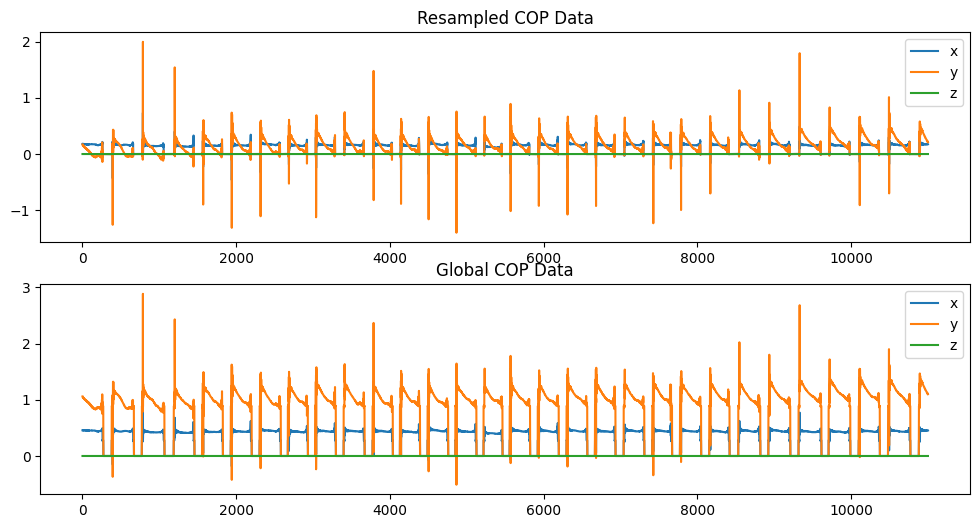

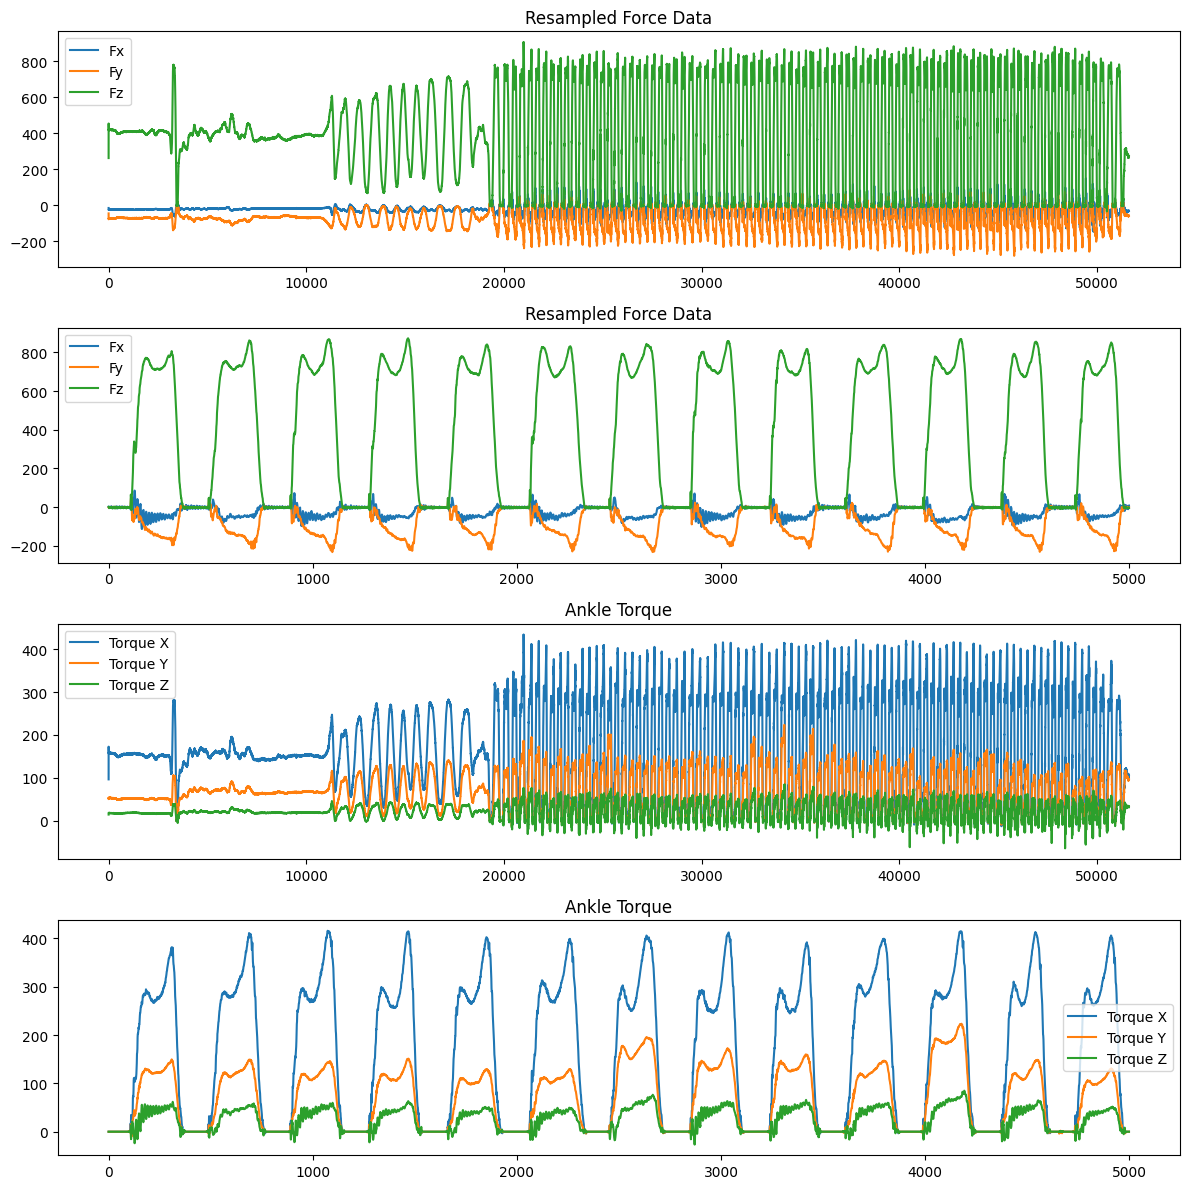

"Cuz the ankle torque is only about Y axis, so we only consider the Torque Y. It's about 50~80 Nm, the mean data in the paper is about 0.8~1 Nm/kg.Consider the weight of adult is about 75kg."

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample_poly

# 1. Read Force data
force_df = pd.read_csv('Subject_01/T01-10/S01_T01_f_6.tsv', sep='\t', skiprows=27, header=None)

# 2. Get the Force, COP data
Force_right = force_df.iloc[:, 0:3].values.T  # Fx, Fy, Fz
COP_right = force_df.iloc[:, 6:9].values.T  # COPx, COPy, COPz

# 4. Resample
Force_right_resampled = resample_poly(Force_right, up=1, down=4, axis=1)  # (3, 51613)
COP_right_resampled = resample_poly(COP_right, up=1, down=4, axis=1)  # (3, 51613)

# 5. Check if the data shapes are matched
print(f"Resampled Force shape: {Force_right_resampled.shape}, COP shape: {COP_right_resampled.shape}")

# Convert mm to meters
COP_right_resampled /= 1000
FORCE_PLATE_OFFSET = np.array([279.4, 889.0, 0.0]) / 1000  # mm → m

# Copy result
COP_right_global = COP_right_resampled.copy()

# Find which lines are not [0, 0, 0]（The COP has real value at these moments）
non_zero_mask = ~(COP_right_resampled == 0).all(axis=0)  # shape: (n_samples,)

# Add offset to non-zero cols
COP_right_global[:, non_zero_mask] += FORCE_PLATE_OFFSET[:, np.newaxis]

# 8. Plot Data
plt.figure(figsize=(12, 6))

# Plot COP Data
plt.subplot(2, 1, 1)
plt.plot(COP_right_resampled[0, 20000:31000], label='x')
plt.plot(COP_right_resampled[1, 20000:31000], label='y')
plt.plot(COP_right_resampled[2, 20000:31000], label='z')
plt.legend()
plt.title("Resampled COP Data")

# Plot Global COP Data
plt.subplot(2, 1, 2)
plt.plot(COP_right_global[0, 20000:31000], label='x')
plt.plot(COP_right_global[1, 20000:31000], label='y')
plt.plot(COP_right_global[2, 20000:31000], label='z')
plt.legend()
plt.title("Global COP Data")


# 6. Calculate ankle torque
def calculate_ankle_torque(ankle_position, cop, force):
    n_frames = cop.shape[1]

    # 1. Create a mask for frames where COP is not all zeros
    non_zero_mask = ~(cop == 0).all(axis=0)  # shape: (n_frames,)

    # 2. Initialize outputs with zeros for all frames
    ankle_torque = np.zeros_like(force)
    moment_arm = np.zeros_like(cop)

    # 3. Compute moment arm and torque only for valid (non-zero COP) frames
    moment_arm[:, non_zero_mask] = cop[:, non_zero_mask] - ankle_position[:, non_zero_mask]
    torque_valid = np.cross(moment_arm[:, non_zero_mask].T, force[:, non_zero_mask].T).T
    ankle_torque[:, non_zero_mask] = torque_valid
    
    # Debug info
    print(f"Moment Arm shape: {moment_arm.shape}, Force shape: {force.shape}")
    print(f"Computed torque for {non_zero_mask.sum()} frames out of {n_frames}")

    return ankle_torque, moment_arm


AnkleTorque, moment_arm = calculate_ankle_torque(AnklePosition, COP_right_global, Force_right_resampled)
print(f"Moment Arm X Min/Max: {moment_arm[0, :].min()} to {moment_arm[0, :].max()} m")
print(f"Ankle Position X Min/Max: {AnklePosition[0, :].min()} to {AnklePosition[0, :].max()} m")
print(f"COP Right X Min/Max: {COP_right_resampled[0, :].min()} to {COP_right_resampled[0, :].max()} m")

# 7. Only consider about Y-axis
AnkleTorque_Y = AnkleTorque[1, :]

# 8. Calculating the mean, max and min of`AnkleTorque_Y`
mean_torque = np.mean(AnkleTorque_Y)
max_torque = np.max(AnkleTorque_Y)
min_torque = np.min(AnkleTorque_Y)

# 10. Print results
print(f"Mean Ankle Torque (Y-axis): {mean_torque:.2f} N·m")
print(f"Max Ankle Torque (Y-axis): {max_torque:.2f} N·m")
print(f"Min Ankle Torque (Y-axis): {min_torque:.2f} N·m")

print("Processed Torque data preview (first 10 frames):")
print(AnkleTorque[:, 20000:20010]) # The beginning frame of walking

"""# 7. Save to CSV
df = pd.DataFrame({
    'Frame': np.arange(AnkleTorque.shape[1]),
    'Torque_X': AnkleTorque[0, :],
    'Torque_Y': AnkleTorque[1, :],
    'Torque_Z': AnkleTorque[2, :]
})
df.to_csv('AnkleTorqueResults.csv', index=False, encoding='utf-8-sig')

print("Finished to calculate the torque, save as 'AnkleTorqueResults.csv'")"""

existing_df = pd.read_csv('/Users/sophialiu/Downloads/Fully Processed Dataset with all the 4 variables/subject_processed/S01/20230419_1055_S01_T01_RIGHT.csv', sep=',')

# Finding the first 0 in "sync" col
sync_zero_index = existing_df[existing_df['sync'] == 0].index[0]

# Inserting the torque data from this row
existing_df.loc[sync_zero_index:, 'Torque_X'] = AnkleTorque[0, :len(existing_df) - sync_zero_index]
existing_df.loc[sync_zero_index:, 'Torque_Y'] = AnkleTorque[1, :len(existing_df) - sync_zero_index]
existing_df.loc[sync_zero_index:, 'Torque_Z'] = AnkleTorque[2, :len(existing_df) - sync_zero_index]

# List all column names, placing Torque_X, Torque_Y, and Torque_Z last
column_order = [col for col in existing_df.columns if col not in ['Torque_X', 'Torque_Y', 'Torque_Z']]
column_order += ['Torque_X', 'Torque_Y', 'Torque_Z']

# Reorder the DataFrame
existing_df = existing_df[column_order]

# Saving new file
existing_df.to_csv('/Users/sophialiu/Downloads/Fully Processed Dataset with all the 4 variables/subject_processed/S01/20230419_1055_S01_T01_RIGHT.csv', sep=',', index=False)

# 8. Plot Data
plt.figure(figsize=(12, 12))

# Plot Force Data
plt.subplot(4, 1, 1)
plt.plot(Force_right_resampled[0, :], label='Fx')
plt.plot(Force_right_resampled[1, :], label='Fy')
plt.plot(Force_right_resampled[2, :], label='Fz')
plt.legend()
plt.title("Resampled Force Data")

# Plot Force Data
plt.subplot(4, 1, 2)
plt.plot(Force_right_resampled[0, 30000:35000], label='Fx')
plt.plot(Force_right_resampled[1, 30000:35000], label='Fy')
plt.plot(Force_right_resampled[2, 30000:35000], label='Fz')
plt.legend()
plt.title("Resampled Force Data")

# Plot Ankle Torque Data
plt.subplot(4, 1, 3)
plt.plot(AnkleTorque[0, :], label='Torque X')
plt.plot(AnkleTorque[1, :], label='Torque Y')
plt.plot(AnkleTorque[2, :], label='Torque Z')
plt.legend()
plt.title("Ankle Torque")

# Plot Ankle Torque Data
plt.subplot(4, 1, 4)
plt.plot(AnkleTorque[0, 30000:35000], label='Torque X')
plt.plot(AnkleTorque[1, 30000:35000], label='Torque Y')
plt.plot(AnkleTorque[2, 30000:35000], label='Torque Z')
plt.legend()
plt.title("Ankle Torque")
plt.tight_layout()
plt.show()

"""Cuz the ankle torque is only about Y axis, so we only consider the Torque Y. It's about 50~80 Nm, the mean data in the paper is about 0.8~1 Nm/kg.Consider the weight of adult is about 75kg."""